# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [14]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
import geoviews 
import numpy as np

# Import API key
from api_keys import geoapify_key_hotels
from requests.structures import CaseInsensitiveDict


In [15]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data_file.csv")

# Display sample data
city_data_df

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,ponta do sol,32.6667,-17.1000,64.00,48,10,7.78,PT,1675704725
1,1,bluff,-46.6000,168.3333,60.91,69,58,19.42,NZ,1675704726
2,2,bathsheba,13.2167,-59.5167,84.81,61,75,20.71,BB,1675704454
3,3,talnakh,69.4865,88.3972,-9.80,98,100,5.19,RU,1675704728
4,4,buin,-33.7333,-70.7500,93.43,26,0,9.80,CL,1675704505
...,...,...,...,...,...,...,...,...,...,...
542,542,muisne,0.6000,-80.0333,81.41,74,72,9.71,EC,1675705010
543,543,artesia,33.8658,-118.0831,62.22,67,0,3.44,US,1675705011
544,544,namasuba,0.6894,32.4214,67.59,63,63,2.46,UG,1675705011
545,545,kabinda,-6.1333,24.4833,69.60,70,88,1.92,CD,1675705011


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

C:\Users\Brittni\anaconda3\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


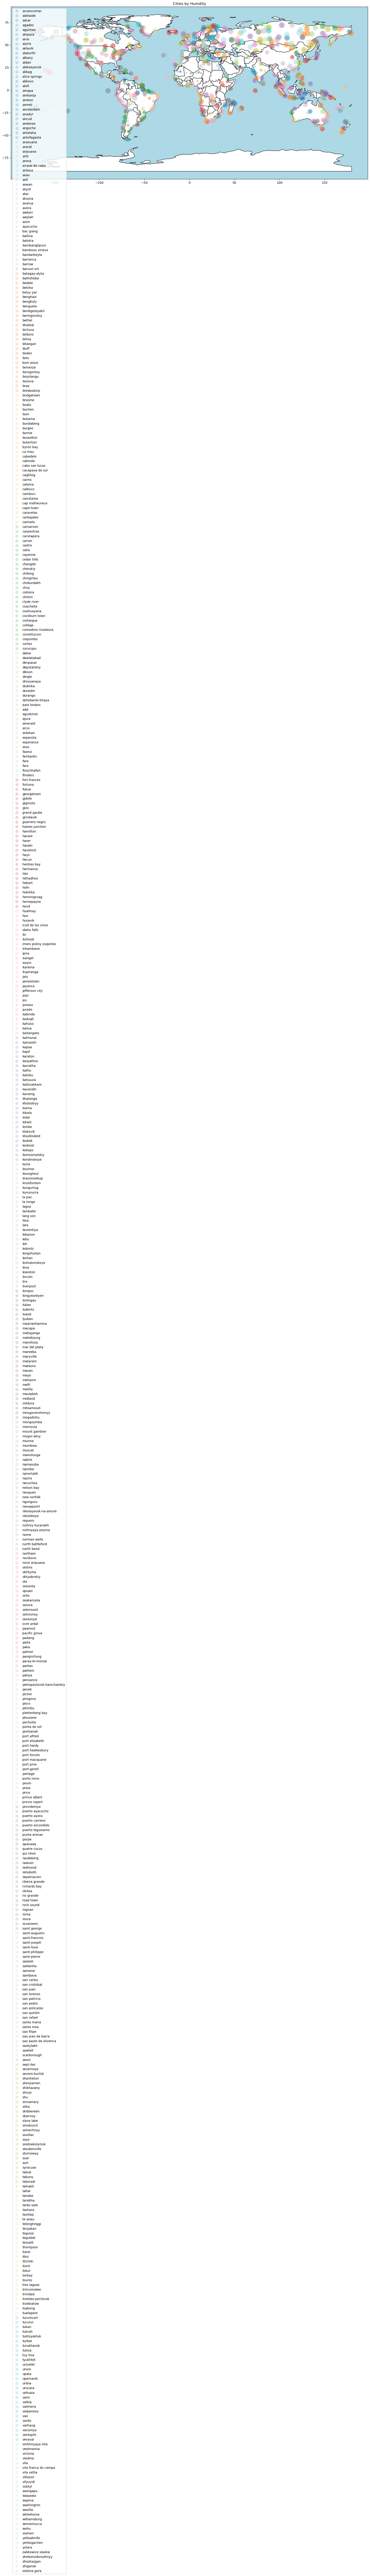

In [16]:


# Convert the data to a GeoDataFrame
city_gdf = gpd.GeoDataFrame(city_data_df, geometry=gpd.points_from_xy(city_data_df['Lng'].values, city_data_df['Lat'].values))
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create the map
fig, ax = plt.subplots(figsize=(30,10))
world_gdf.plot(ax=ax, color='white', edgecolor='black')

Humidity = (city_gdf['Humidity'] - city_gdf['Humidity'].min()) / (city_gdf['Humidity'].max() - city_gdf['Humidity'].min())
# Humidity level markers
city_gdf.plot(ax=ax, markersize=city_gdf['Humidity']*3, column='City', cmap='tab20', alpha=0.4, legend=True)
city_gdf.plot(ax=ax, markersize=city_gdf['Humidity']*1, column='City', cmap='tab20', alpha=0.2, legend=True, categorical=False)

plt.title('Cities by Humdity')
ax.set_facecolor('lightblue')

# Show the plot
plt.show()



### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [17]:
max_humidity_s = city_data_df['Humidity'] < 80
min_humidity_s = city_data_df['Humidity'] > 20

# Narrow down cities that fit criteria and drop any results with null values
comfy_city_df = city_data_df[min_humidity_s & max_humidity_s]

# Drop any rows with null values
comfy_city_df = comfy_city_df.dropna()

# Display sample data
comfy_city_df 

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date,geometry
0,0,ponta do sol,32.6667,-17.1000,64.00,48,10,7.78,PT,1675704725,POINT (-17.10000 32.66670)
1,1,bluff,-46.6000,168.3333,60.91,69,58,19.42,NZ,1675704726,POINT (168.33330 -46.60000)
2,2,bathsheba,13.2167,-59.5167,84.81,61,75,20.71,BB,1675704454,POINT (-59.51670 13.21670)
4,4,buin,-33.7333,-70.7500,93.43,26,0,9.80,CL,1675704505,POINT (-70.75000 -33.73330)
7,7,severo-kurilsk,50.6789,156.1250,25.68,70,94,9.06,RU,1675704740,POINT (156.12500 50.67890)
...,...,...,...,...,...,...,...,...,...,...,...
542,542,muisne,0.6000,-80.0333,81.41,74,72,9.71,EC,1675705010,POINT (-80.03330 0.60000)
543,543,artesia,33.8658,-118.0831,62.22,67,0,3.44,US,1675705011,POINT (-118.08310 33.86580)
544,544,namasuba,0.6894,32.4214,67.59,63,63,2.46,UG,1675705011,POINT (32.42140 0.68940)
545,545,kabinda,-6.1333,24.4833,69.60,70,88,1.92,CD,1675705011,POINT (24.48330 -6.13330)


### Step 3: Create a new DataFrame called `hotel_df`.

In [18]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = comfy_city_df [['City', 'Country', 'Lat', 'Lng', 'Humidity']].copy()

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df = hotel_df.assign(Hotel_Name='')

# Display sample data
hotel_df

,City,Country,Lat,Lng,Humidity,Hotel_Name
0,ponta do sol,PT,32.6667,-17.1000,48,
1,bluff,NZ,-46.6000,168.3333,69,
2,bathsheba,BB,13.2167,-59.5167,61,
4,buin,CL,-33.7333,-70.7500,26,
7,severo-kurilsk,RU,50.6789,156.1250,70,
...,...,...,...,...,...,...
542,muisne,EC,0.6000,-80.0333,74,
543,artesia,US,33.8658,-118.0831,67,
544,namasuba,UG,0.6894,32.4214,63,
545,kabinda,CD,-6.1333,24.4833,70,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [19]:
# Set parameters to search for a hotel
radius = 10000
params = {"q": "Hotel_Name", 
          "categories":"accommodation.hotel", 
    "radius": radius,
    "apiKey": geoapify_key_hotels}


# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iloc[:20].iterrows():    # DEBUG-Remove iloc
    # get latitude, longitude from the DataFrame
    lat = row['Lat']
    lng = row['Lng']
    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{lng},{lat},{radius}"
    #params["filter"] = 'withinCircle(coordinates, {}, {}, {})'.format(city_data_df["Lng"], city_data_df["Lat"], 10000)
    #params["bias"] = '{},{}'.format(city_data_df["Lng"], city_data_df["Lat"])
    params["bias"] = f"proximity:{lng},{lat}"

   # Set base URL
    base_url = "https://api.geoapify.com/v2/places"

    # Make and API request using the params dictionaty
    response = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = response.json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel_Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel_Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel_Name']}")

# Display sample data
hotel_df.head(22)

Starting hotel search
ponta do sol - nearest hotel: Estalagem Ponta do Sol
bluff - nearest hotel: No hotel found
bathsheba - nearest hotel: Atlantis Hotel
buin - nearest hotel: Hotel Casa Real
severo-kurilsk - nearest hotel: "Дом рыбака"
lebu - nearest hotel: No hotel found
mahebourg - nearest hotel: Grand Bel Air
ushuaia - nearest hotel: Apart Hotel Aires del Beagle
mataura - nearest hotel: No hotel found
shiraz - nearest hotel: هتل نصیرالملک
vila - nearest hotel: Hotel Miracastro
portage - nearest hotel: No hotel found
cidreira - nearest hotel: Hotel Castelo
bom jesus - nearest hotel: Hotel Brasão
carver - nearest hotel: No hotel found
taltal - nearest hotel: Hostería Taltal
leibnitz - nearest hotel: Hotel zur alten Post
ancud - nearest hotel: Cabañas
rikitea - nearest hotel: Chez Bianca & Benoit
aswan - nearest hotel: Yaseen hotel


,City,Country,Lat,Lng,Humidity,Hotel_Name
0,ponta do sol,PT,32.6667,-17.1000,48,Estalagem Ponta do Sol
1,bluff,NZ,-46.6000,168.3333,69,No hotel found
2,bathsheba,BB,13.2167,-59.5167,61,Atlantis Hotel
4,buin,CL,-33.7333,-70.7500,26,Hotel Casa Real
7,severo-kurilsk,RU,50.6789,156.1250,70,"""Дом рыбака"""
8,lebu,CL,-37.6167,-73.6500,65,No hotel found
10,mahebourg,MU,-20.4081,57.7000,78,Grand Bel Air
12,ushuaia,AR,-54.8000,-68.3000,67,Apart Hotel Aires del Beagle
13,mataura,NZ,-46.1927,168.8643,57,No hotel found
16,shiraz,IR,29.6036,52.5388,47,هتل نصیرالملک


In [20]:
hotel_df

,City,Country,Lat,Lng,Humidity,Hotel_Name
0,ponta do sol,PT,32.6667,-17.1000,48,Estalagem Ponta do Sol
1,bluff,NZ,-46.6000,168.3333,69,No hotel found
2,bathsheba,BB,13.2167,-59.5167,61,Atlantis Hotel
4,buin,CL,-33.7333,-70.7500,26,Hotel Casa Real
7,severo-kurilsk,RU,50.6789,156.1250,70,"""Дом рыбака"""
...,...,...,...,...,...,...
542,muisne,EC,0.6000,-80.0333,74,
543,artesia,US,33.8658,-118.0831,67,
544,namasuba,UG,0.6894,32.4214,63,
545,kabinda,CD,-6.1333,24.4833,70,


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

In [25]:
# Configure the map plot
map_plot = hotel_df.hvplot.points(
    "Lng", 
    "Lat", 
    geo = True, 
    size = "Humidity",
    scale = 1,
    color = "City",
    alpha = 0.5,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    hover_cols = ["Hotel Name", "Country"]
)

# Display the map
map_plot


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (City,Humidity,Country)